In [3]:
from typing import Callable, Dict, Iterable, Self
from numpy.typing import NDArray
import datasets
import tensorflow as tf
import numpy as np
import einops
import pandas as pd
import pickle
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import json

import flagon

# Solar Home Dataset

In [4]:
with open("data/solar_home_data.pkl", 'rb') as f:
    data = pickle.load(f)

with open("data/customer_regions.json", 'r') as f:
    customer_regions = json.load(f)

def get_customer_data(customer=1):
    idx = np.arange(24, len(data[customer]))
    expanded_idx = np.array([np.arange(i - 24, i - 1) for i in idx])
    return data[customer][expanded_idx], data[customer][idx, 0]

In [5]:
customer_regions

{'1': 1,
 '2': 3,
 '3': 3,
 '4': 3,
 '5': 3,
 '6': 3,
 '7': 3,
 '8': 1,
 '9': 3,
 '10': 3,
 '14': 3,
 '15': 3,
 '18': 1,
 '19': 3,
 '23': 3,
 '27': 1,
 '29': 3,
 '30': 3,
 '35': 4,
 '36': 2,
 '37': 3,
 '39': 3,
 '41': 4,
 '42': 3,
 '43': 3,
 '49': 3,
 '51': 4,
 '53': 1,
 '54': 3,
 '56': 3,
 '59': 4,
 '61': 3,
 '64': 3,
 '65': 1,
 '66': 3,
 '68': 4,
 '69': 3,
 '70': 3,
 '71': 3,
 '73': 4,
 '75': 3,
 '77': 4,
 '81': 1,
 '84': 3,
 '87': 4,
 '88': 4,
 '94': 1,
 '95': 1,
 '96': 0,
 '98': 3,
 '99': 0,
 '105': 1,
 '107': 4,
 '108': 4,
 '110': 4,
 '112': 1,
 '118': 3,
 '119': 4,
 '122': 4,
 '123': 1,
 '125': 4,
 '126': 3,
 '127': 3,
 '129': 0,
 '133': 4,
 '137': 3,
 '140': 3,
 '145': 3,
 '146': 4,
 '148': 4,
 '150': 2,
 '151': 4,
 '154': 1,
 '155': 3,
 '156': 3,
 '158': 3,
 '160': 3,
 '161': 1,
 '163': 4,
 '167': 3,
 '168': 3,
 '171': 3,
 '173': 3,
 '174': 1,
 '178': 3,
 '184': 3,
 '186': 3,
 '187': 0,
 '193': 3,
 '194': 3,
 '196': 3,
 '202': 3,
 '204': 1,
 '206': 3,
 '208': 1,
 '209': 1,
 '21

In [17]:
data_collector_counts = {}
client_ids = {}
for customer, region in customer_regions.items():
    data_collector = region
    if not data_collector_counts.get(data_collector):
        data_collector_counts[data_collector] = 0
    client_ids[f"{data_collector}-{data_collector_counts[data_collector]}"] = int(customer)
    data_collector_counts[data_collector] += 1

In [23]:
client_ids['0-27']

KeyError: '0-27'

In [26]:
data_collector_counts

{1: 69, 3: 114, 4: 73, 2: 16, 0: 27, 5: 1}

In [38]:
class Client(flagon.Client):
    def __init__(self, data, create_model_fn):
        self.data = data
        self.model = create_model_fn()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.data['train']['X'], self.data['train']['Y'], epochs=config['num_epochs'])
        return self.model.get_weights(), len(self.data['train']), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, mae, rmse = self.model.evaluate(self.data['test']['X'], self.data['test']['Y'])
        return len(self.data['test']), {'loss': loss, 'mean absolute error': mae, 'root mean squared error': rmse}

In [7]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((23, 4))
    # x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Conv1D(64, 5, activation="relu")(inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(32, 2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="mean_squared_error",
        metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [35]:
def create_clients(create_model_fn, nclients, seed=None):
    def create_client(client_id: str):
        client_X, client_Y = get_customer_data(client_ids[client_id])
        client_data = {"train": {"X": client_X[:300], "Y": client_Y[:300]}, "test": {"X": client_X[300:], "Y": client_Y[300:]}}
        return Client(client_data, create_model_fn)
    return create_client

In [39]:
server = flagon.Server(create_model().get_weights(), {"num_rounds": 1, "num_episodes": 1, "num_epochs": 1})
network_arch = {
    "clients": [{"clients": 0} for _ in data_collector_counts.keys()],
}
for k, v in data_collector_counts.items():
    network_arch['clients'][k]['clients'] = v
flagon.start_simulation(
    server,
    create_clients(create_model, flagon.common.count_clients(network_arch)),
    network_arch
)

| flagon INFO @ 2023-07-26 13:20:11,521 in middle_server.py:31 | Registering 27 clients to middle server
| flagon INFO @ 2023-07-26 13:20:16,170 in middle_server.py:31 | Registering 69 clients to middle server
| flagon INFO @ 2023-07-26 13:20:16,981 in middle_server.py:31 | Registering 16 clients to middle server
| flagon INFO @ 2023-07-26 13:20:22,747 in middle_server.py:31 | Registering 114 clients to middle server
| flagon INFO @ 2023-07-26 13:20:26,447 in middle_server.py:31 | Registering 73 clients to middle server
| flagon INFO @ 2023-07-26 13:20:26,499 in middle_server.py:31 | Registering 1 clients to middle server
| flagon INFO @ 2023-07-26 13:20:26,500 in server.py:54 | Registering 6 clients to the server
| flagon INFO @ 2023-07-26 13:20:26,500 in server.py:64 | Starting training on the server for 1 rounds
| flagon INFO @ 2023-07-26 13:20:26,500 in middle_server.py:38 | Starting training on middle server for 1 episodes


10/10 [==============================] - 1s 1ms/step - loss: 1932.0537 - mean_absolute_error: 15.3339 - root_mean_squared_error: 43.9551


| flagon INFO @ 2023-07-26 13:20:41,968 in middle_server.py:53 | Completed middle server training in 15.46733570098877s
| flagon INFO @ 2023-07-26 13:20:41,968 in middle_server.py:54 | Distributed final metrics: [{'loss': 2068.037841796875, 'mean_absolute_error': 16.265117645263672, 'root_mean_squared_error': 45.475685119628906}, {'loss': 1603.8363037109375, 'mean_absolute_error': 13.80884075164795, 'root_mean_squared_error': 40.04792404174805}, {'loss': 2157.254150390625, 'mean_absolute_error': 17.127681732177734, 'root_mean_squared_error': 46.446250915527344}, {'loss': 1534.557373046875, 'mean_absolute_error': 13.616704940795898, 'root_mean_squared_error': 39.17342758178711}, {'loss': 1434.0352783203125, 'mean_absolute_error': 13.115798950195312, 'root_mean_squared_error': 37.86865997314453}, {'loss': 1789.5220947265625, 'mean_absolute_error': 14.42274284362793, 'root_mean_squared_error': 42.30274200439453}, {'loss': 2116.946533203125, 'mean_absolute_error': 15.699617385864258, 'root

10/10 [==============================] - 1s 1ms/step - loss: 1772.4650 - mean_absolute_error: 15.5118 - root_mean_squared_error: 42.1007


| flagon INFO @ 2023-07-26 13:21:22,752 in middle_server.py:53 | Completed middle server training in 40.782859325408936s
| flagon INFO @ 2023-07-26 13:21:22,753 in middle_server.py:54 | Distributed final metrics: [{'loss': 2204.0087890625, 'mean_absolute_error': 16.017147064208984, 'root_mean_squared_error': 46.94687271118164}, {'loss': 2148.40576171875, 'mean_absolute_error': 17.210433959960938, 'root_mean_squared_error': 46.35089874267578}, {'loss': 2060.493408203125, 'mean_absolute_error': 15.548196792602539, 'root_mean_squared_error': 45.39265823364258}, {'loss': 1383.615234375, 'mean_absolute_error': 13.310222625732422, 'root_mean_squared_error': 37.19697952270508}, {'loss': 1625.400146484375, 'mean_absolute_error': 14.143232345581055, 'root_mean_squared_error': 40.31624984741211}, {'loss': 1765.051025390625, 'mean_absolute_error': 14.74776840209961, 'root_mean_squared_error': 42.01251220703125}, {'loss': 1923.825439453125, 'mean_absolute_error': 14.09048843383789, 'root_mean_squa

10/10 [==============================] - 1s 1ms/step - loss: 1351.1576 - mean_absolute_error: 12.3944 - root_mean_squared_error: 36.7581


| flagon INFO @ 2023-07-26 13:21:31,830 in middle_server.py:53 | Completed middle server training in 9.075769901275635s
| flagon INFO @ 2023-07-26 13:21:31,830 in middle_server.py:54 | Distributed final metrics: [{'loss': 1654.423583984375, 'mean_absolute_error': 14.28824520111084, 'root_mean_squared_error': 40.67460632324219}, {'loss': 2036.6785888671875, 'mean_absolute_error': 15.22532844543457, 'root_mean_squared_error': 45.129573822021484}, {'loss': 1387.3580322265625, 'mean_absolute_error': 12.741962432861328, 'root_mean_squared_error': 37.247257232666016}, {'loss': 2372.3642578125, 'mean_absolute_error': 16.460031509399414, 'root_mean_squared_error': 48.7069206237793}, {'loss': 2202.955322265625, 'mean_absolute_error': 16.560718536376953, 'root_mean_squared_error': 46.93564987182617}, {'loss': 2461.469482421875, 'mean_absolute_error': 17.2198543548584, 'root_mean_squared_error': 49.613197326660156}, {'loss': 2073.839599609375, 'mean_absolute_error': 16.0863094329834, 'root_mean_s

10/10 [==============================] - 1s 1ms/step - loss: 2454.2781 - mean_absolute_error: 16.5932 - root_mean_squared_error: 49.5407


| flagon INFO @ 2023-07-26 13:22:39,360 in middle_server.py:53 | Completed middle server training in 67.52863907814026s
| flagon INFO @ 2023-07-26 13:22:39,361 in middle_server.py:54 | Distributed final metrics: [{'loss': 2286.122802734375, 'mean_absolute_error': 16.13750457763672, 'root_mean_squared_error': 47.81341552734375}, {'loss': 2408.09814453125, 'mean_absolute_error': 17.12133026123047, 'root_mean_squared_error': 49.0723762512207}, {'loss': 1322.5516357421875, 'mean_absolute_error': 12.880694389343262, 'root_mean_squared_error': 36.36690139770508}, {'loss': 2308.092529296875, 'mean_absolute_error': 16.79876136779785, 'root_mean_squared_error': 48.04261016845703}, {'loss': 1444.28955078125, 'mean_absolute_error': 12.868871688842773, 'root_mean_squared_error': 38.00381088256836}, {'loss': 2052.204833984375, 'mean_absolute_error': 15.689167976379395, 'root_mean_squared_error': 45.301265716552734}, {'loss': 2180.983642578125, 'mean_absolute_error': 16.145490646362305, 'root_mean_s

10/10 [==============================] - 1s 1ms/step - loss: 2280.8083 - mean_absolute_error: 16.2782 - root_mean_squared_error: 47.7578


| flagon INFO @ 2023-07-26 13:23:21,165 in middle_server.py:53 | Completed middle server training in 41.802247524261475s
| flagon INFO @ 2023-07-26 13:23:21,165 in middle_server.py:54 | Distributed final metrics: [{'loss': 2083.32373046875, 'mean_absolute_error': 15.565491676330566, 'root_mean_squared_error': 45.64344024658203}, {'loss': 2117.952880859375, 'mean_absolute_error': 15.768902778625488, 'root_mean_squared_error': 46.02122116088867}, {'loss': 1840.9822998046875, 'mean_absolute_error': 15.081795692443848, 'root_mean_squared_error': 42.90666961669922}, {'loss': 2361.18408203125, 'mean_absolute_error': 17.195606231689453, 'root_mean_squared_error': 48.592018127441406}, {'loss': 2444.998779296875, 'mean_absolute_error': 17.897001266479492, 'root_mean_squared_error': 49.446929931640625}, {'loss': 2572.973388671875, 'mean_absolute_error': 17.276527404785156, 'root_mean_squared_error': 50.724483489990234}, {'loss': 2842.8291015625, 'mean_absolute_error': 18.60746192932129, 'root_me

10/10 [==============================] - 1s 1ms/step - loss: 2714.1445 - mean_absolute_error: 18.2196 - root_mean_squared_error: 52.0975


| flagon INFO @ 2023-07-26 13:23:21,740 in middle_server.py:53 | Completed middle server training in 0.5731160640716553s
| flagon INFO @ 2023-07-26 13:23:21,740 in middle_server.py:54 | Distributed final metrics: [{'loss': 2714.14453125, 'mean_absolute_error': 18.219554901123047, 'root_mean_squared_error': 52.09745407104492}]
| flagon INFO @ 2023-07-26 13:23:21,740 in middle_server.py:56 | Aggregated final metrics {'loss': 2714.14453125, 'mean_absolute_error': 18.219554901123047, 'root_mean_squared_error': 52.09745407104492}
| flagon INFO @ 2023-07-26 13:23:21,742 in server.py:88 | Completed server training in 175.2414424419403s
| flagon INFO @ 2023-07-26 13:23:21,742 in server.py:89 | Distributed metrics: {1: [{'loss': 1812.5338270399307, 'mean_absolute_error': 14.79762691921658, 'root_mean_squared_error': 42.43760582252785}, {'loss': 2017.0869830587635, 'mean_absolute_error': 15.491820459780486, 'root_mean_squared_error': 44.7550243432971}, {'loss': 2001.483627319336, 'mean_absolute_

264/264 [==============================] - 0s 689us/step - loss: 0.6824 - mean_absolute_error: 0.6257 - root_mean_squared_error: 0.8261


| flagon INFO @ 2023-07-26 13:23:29,414 in middle_server.py:70 | Completed middle server analytics in 7.670470952987671s
| flagon INFO @ 2023-07-26 13:23:29,414 in middle_server.py:72 | Aggregated final metrics {'loss': 1.4597380492422316, 'mean absolute error': 0.8650085793601142, 'root mean squared error': 1.1601626718485798}
| flagon INFO @ 2023-07-26 13:23:29,415 in middle_server.py:61 | Performing analytics on middle server


264/264 [==============================] - 0s 701us/step - loss: 3.2233 - mean_absolute_error: 1.2229 - root_mean_squared_error: 1.7954


| flagon INFO @ 2023-07-26 13:23:49,375 in middle_server.py:70 | Completed middle server analytics in 19.960026502609253s
| flagon INFO @ 2023-07-26 13:23:49,375 in middle_server.py:72 | Aggregated final metrics {'loss': 1.647159832543221, 'mean absolute error': 0.8841282530971195, 'root mean squared error': 1.2125335171602774}
| flagon INFO @ 2023-07-26 13:23:49,376 in middle_server.py:61 | Performing analytics on middle server


264/264 [==============================] - 0s 683us/step - loss: 0.4257 - mean_absolute_error: 0.5431 - root_mean_squared_error: 0.6525


| flagon INFO @ 2023-07-26 13:23:53,947 in middle_server.py:70 | Completed middle server analytics in 4.57076096534729s
| flagon INFO @ 2023-07-26 13:23:53,947 in middle_server.py:72 | Aggregated final metrics {'loss': 1.6210130397230387, 'mean absolute error': 0.9354492612183094, 'root mean squared error': 1.2322406098246574}
| flagon INFO @ 2023-07-26 13:23:53,947 in middle_server.py:61 | Performing analytics on middle server


264/264 [==============================] - 0s 724us/step - loss: 0.2466 - mean_absolute_error: 0.4045 - root_mean_squared_error: 0.4966


| flagon INFO @ 2023-07-26 13:24:30,319 in middle_server.py:70 | Completed middle server analytics in 36.37122440338135s
| flagon INFO @ 2023-07-26 13:24:30,319 in middle_server.py:72 | Aggregated final metrics {'loss': 1.4901631465345098, 'mean absolute error': 0.7960567892643443, 'root mean squared error': 1.1443452233808082}
| flagon INFO @ 2023-07-26 13:24:30,320 in middle_server.py:61 | Performing analytics on middle server


264/264 [==============================] - 0s 721us/step - loss: 1.6235 - mean_absolute_error: 0.8953 - root_mean_squared_error: 1.2742


| flagon INFO @ 2023-07-26 13:24:52,198 in middle_server.py:70 | Completed middle server analytics in 21.878490209579468s
| flagon INFO @ 2023-07-26 13:24:52,199 in middle_server.py:72 | Aggregated final metrics {'loss': 1.5481293556624895, 'mean absolute error': 0.8853661515941359, 'root mean squared error': 1.1802126626445824}
| flagon INFO @ 2023-07-26 13:24:52,199 in middle_server.py:61 | Performing analytics on middle server


264/264 [==============================] - 0s 723us/step - loss: 1.5139 - mean_absolute_error: 0.7217 - root_mean_squared_error: 1.2304


| flagon INFO @ 2023-07-26 13:24:52,497 in middle_server.py:70 | Completed middle server analytics in 0.2977297306060791s
| flagon INFO @ 2023-07-26 13:24:52,497 in middle_server.py:72 | Aggregated final metrics {'loss': 1.5138851404190063, 'mean absolute error': 0.7216605544090271, 'root mean squared error': 1.2304004430770874}
| flagon INFO @ 2023-07-26 13:24:52,498 in server.py:112 | Completed server analytics in 90.75435876846313s
| flagon INFO @ 2023-07-26 13:24:52,498 in server.py:114 | Aggregated final metrics {'loss': 1.54469697073102, 'mean absolute error': 0.851437109609445, 'root mean squared error': 1.1751544495423636}


In [47]:
X = server.client_manager.clients[0].client_manager.clients[0].data['test']['X']
Y = server.client_manager.clients[0].client_manager.clients[0].data['test']['Y']
model = server.client_manager.clients[0].client_manager.clients[0].model

2/2 [==============================] - 0s 2ms/step


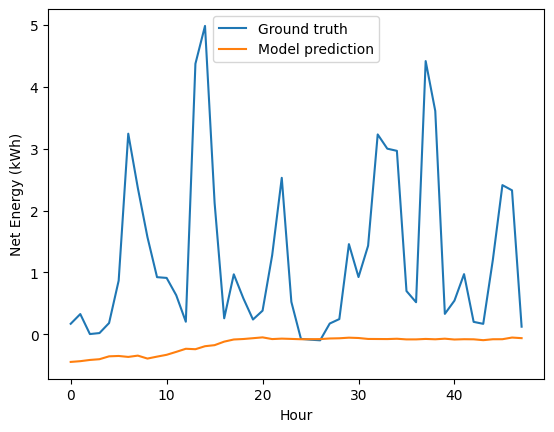

In [48]:
subset_Y = Y[:48]
plt.plot(np.arange(len(subset_Y)), subset_Y, '-', label="Ground truth")

preds = model.predict(X[:48])
plt.plot(np.arange(len(preds)), preds, '-', label="Model prediction")
plt.xlabel("Hour")
plt.ylabel("Net Energy (kWh)")
plt.legend()
plt.show()

# Electricity Consumption Dataset

In [57]:
with open("data/electricity_consumption_2020-2021.pkl", 'rb') as f:
    electricity_con_data = pickle.load(f)

with open("data/central_coast_hunter_weather.pkl", 'rb') as f:
    weather_data = pickle.load(f)

In [58]:
def get_customer_data(lga=0, customer=0):
    idx = np.arange(30, len(electricity_con_data[lga][customer]))
    expanded_idx = np.array([np.arange(i - 30, i - 1) for i in idx])
    return np.concatenate((electricity_con_data[lga][customer, expanded_idx].reshape(-1, 29, 1), weather_data[str(lga)][expanded_idx]), axis=-1), electricity_con_data[lga][customer, idx]

In [59]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((29, 8))
    # x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Conv1D(64, 5, activation="relu")(inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(32, 2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="mean_squared_error",
        metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [60]:
X, Y = get_customer_data()

In [61]:
model = create_model()
model.fit(X, Y, epochs=10)

Epoch 1/10
11/11 [==============================] - 0s 2ms/step - loss: 641016.3750 - mean_absolute_error: 302.2410 - root_mean_squared_error: 800.6350
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 523.1241 - mean_absolute_error: 16.5749 - root_mean_squared_error: 22.8719
Epoch 3/10
11/11 [==============================] - 0s 2ms/step - loss: 55.0029 - mean_absolute_error: 5.9207 - root_mean_squared_error: 7.4164
Epoch 4/10
11/11 [==============================] - 0s 2ms/step - loss: 27.8753 - mean_absolute_error: 4.2561 - root_mean_squared_error: 5.2797
Epoch 5/10
11/11 [==============================] - 0s 2ms/step - loss: 27.4987 - mean_absolute_error: 4.1738 - root_mean_squared_error: 5.2439
Epoch 6/10
11/11 [==============================] - 0s 2ms/step - loss: 29.8582 - mean_absolute_error: 4.3338 - root_mean_squared_error: 5.4643
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 24.3092 - mean_absolute_error: 3.9646 - root_mean_squ

11/11 [==============================] - 0s 672us/step


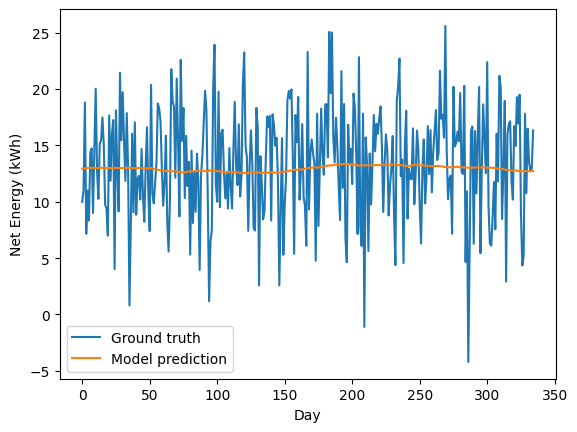

In [62]:
plt.plot(np.arange(len(Y)), Y, '-', label="Ground truth")

preds = model.predict(X)
plt.plot(np.arange(len(preds)), preds, '-', label="Model prediction")
plt.xlabel("Day")
plt.ylabel("Net Energy (kWh)")
plt.legend()
plt.show()